In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Re-import necessary libraries after kernel restart
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# Reload the datasets
train_file_path = "/content/drive/MyDrive/Colab_Notebooks/DATA/Train.csv"
test_file_path = "/content/drive/MyDrive/Colab_Notebooks/DATA/Test.csv"
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)


In [3]:

# Step 1: Prepare the Train and Test Data
# Drop irrelevant columns (IDs and Date)
columns_to_drop = ['ID_Zindi', 'ID']
train_data_cleaned = train_data.drop(columns=columns_to_drop)
test_data_cleaned = test_data.drop(columns=columns_to_drop)

train_data_cleaned = train_data_cleaned.sort_values('Date').reset_index(drop=True)
test_data_cleaned = test_data_cleaned.sort_values('Date').reset_index(drop=True)

for df in (train_data_cleaned, test_data_cleaned):
    df['Date'] = pd.to_datetime(df['Date'])
    #df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
    #df['date_ofyear'] = df['Date'].dt.day_of_year
    df['DayOfWeek'] =  df['Date'].dt.dayofweek
    df['Day'] =  df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['Year'] =  df['Date'].dt.year
    df.drop(columns=["Date"],inplace=True)

# Step 2: Check for NaN or Infinite Values in the Target Column
invalid_labels = train_data_cleaned['GT_NO2'].isnull() | ~train_data_cleaned['GT_NO2'].apply(lambda x: pd.notna(x) )
#Filter Out Rows with Invalid Target Values
train_data_cleaned = train_data_cleaned[~invalid_labels]
# Split train data into features (X) and target (y)
X = train_data_cleaned.drop('GT_NO2', axis=1)
y = train_data_cleaned['GT_NO2']

X.head()

<ipython-input-3-fcbc5ffcfe33>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])
<ipython-input-3-fcbc5ffcfe33>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,DayOfWeek,Day,Month,Year
0,45.601585,11.903551,0.0,NaN,0.230527,0.559117,0.000024,0.000117,NaN,14440.82126,1,1,1,2019
1,45.396195,9.282700,0.0,NaN,0.471113,0.640860,0.000023,0.000200,NaN,14441.03373,1,1,1,2019
2,45.330361,9.414645,0.0,NaN,0.313861,0.671681,0.000023,0.000175,NaN,14443.24936,1,1,1,2019
3,45.306013,9.485263,0.0,NaN,0.454544,0.694752,0.000023,0.000291,NaN,14444.19946,1,1,1,2019
4,45.081987,9.700788,0.0,NaN,-0.203494,0.586172,0.000024,0.000368,0.000183,14444.03338,1,1,1,2019


In [4]:

# Step 3: Train-Test Split for Evaluation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:

# Step 4: Train the XGBoost Model
xgb_model = xgb.XGBRegressor(n_estimators=150, learning_rate=0.1, max_depth=10, random_state=42)
xgb_model.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [6]:
# Step 5: Evaluate the Model on Validation Set
y_pred_val = xgb_model.predict(X_val)
mse_val = mean_squared_error(y_val, y_pred_val, squared=True)
r2_val = r2_score(y_val, y_pred_val)



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [7]:
# Step 6: Predict on Test Data
y_pred_test = xgb_model.predict(test_data_cleaned)

# Displaying the validation metrics and a sample of test predictions
validation_results = {
    "MSE (Validation)": mse_val,
    "R^2 (Validation)": r2_val
}

validation_results, y_pred_test[:10]  # Displaying first 10 predictions for brevity

({'MSE (Validation)': 46.46974250024772,
  'R^2 (Validation)': 0.8443245774048305},
 array([44.50471 , 35.234642, 34.036938, 29.818163, 40.15962 , 25.34262 ,
        40.91232 , 35.005287, 29.186731, 33.71751 ], dtype=float32))

-----------------

## Parameter Selection:

In [8]:
import matplotlib.pyplot as plt

# Modified function with plotting functionality to visualize results
def parameter_selection_with_plot(n_est, max_depth, random_state=123):
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

    best_mse = float("inf")
    best_params = {'n_estimators': None, 'max_depth': None}
    results = []  # To store results for plotting

    for n in n_est:
        for m in max_depth:
            # Train XGBoost model with the current parameters
            model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=n, max_depth=m, random_state=random_state)
            model.fit(X_train_split, y_train_split)

            # Predict on validation set
            y_val_pred = model.predict(X_val_split)
            mse = mean_squared_error(y_val_split, y_val_pred)
            results.append((n, m, mse))  # Store the result

            # Update the best parameters if current mse is lower than best_mse
            if mse < best_mse:
                best_mse = mse
                best_params['n_estimators'] = n
                best_params['max_depth'] = m

            print(f"n_estimators: {n}, max_depth: {m}, Validation MSE: {mse:.4f}")

    print("\nBest Parameters Found:")
    print(f"n_estimators: {best_params['n_estimators']}, max_depth: {best_params['max_depth']} with Validation MSE: {best_mse:.4f}")

    # Plotting the results
    n_vals = np.array([r[0] for r in results])
    m_vals = np.array([r[1] for r in results])
    mse_vals = np.array([r[2] for r in results])

    # Reshape data for plotting
    N, M = np.meshgrid(np.array(max_depth), np.array(n_est))
    Z = mse_vals.reshape(len(n_est), len(max_depth))

    # Plotting the surface
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(N, M, Z, cmap=cm.coolwarm, edgecolor='k', linewidth=0.5)
    ax.set_xlabel("max_depth")
    ax.set_ylabel("n_estimators")
    ax.set_zlabel("Validation MSE")
    ax.set_title("Validation MSE for Different n_estimators and max_depth")
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    plt.show()



n_estimators: 50, max_depth: 3, Validation MSE: 87.5149
n_estimators: 50, max_depth: 5, Validation MSE: 67.1167
n_estimators: 50, max_depth: 7, Validation MSE: 56.5120
n_estimators: 50, max_depth: 10, Validation MSE: 52.1054
n_estimators: 50, max_depth: 12, Validation MSE: 53.5209
n_estimators: 50, max_depth: 15, Validation MSE: 59.5896
n_estimators: 100, max_depth: 3, Validation MSE: 79.0735
n_estimators: 100, max_depth: 5, Validation MSE: 60.8035
n_estimators: 100, max_depth: 7, Validation MSE: 52.4425
n_estimators: 100, max_depth: 10, Validation MSE: 50.6904
n_estimators: 100, max_depth: 12, Validation MSE: 53.0212
n_estimators: 100, max_depth: 15, Validation MSE: 59.3483
n_estimators: 150, max_depth: 3, Validation MSE: 73.4161
n_estimators: 150, max_depth: 5, Validation MSE: 56.5403
n_estimators: 150, max_depth: 7, Validation MSE: 50.8173
n_estimators: 150, max_depth: 10, Validation MSE: 50.1583
n_estimators: 150, max_depth: 12, Validation MSE: 52.8260
n_estimators: 150, max_depth:

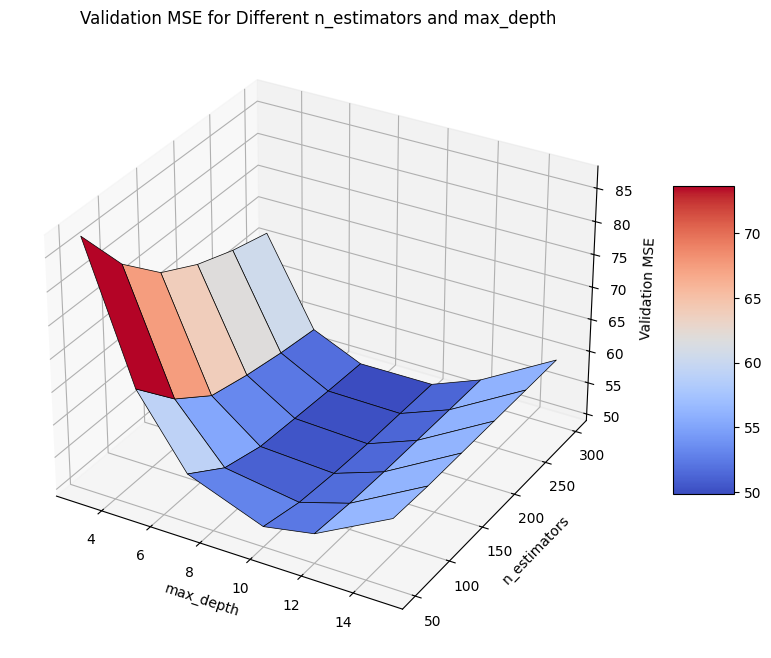

In [9]:
n_est = [50, 100, 150, 200, 250, 300]
max_depth = [3, 5, 7, 10, 12, 15]
parameter_selection_with_plot(n_est, max_depth,random_state=42)

Then we conclude that the best parameters for the model are n_estimators: 300, max_depth: 7

## Result:

In [10]:
xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=7, random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_val = xgb_model.predict(X_val)
mse_val = mean_squared_error(y_val, y_pred_val, squared=True)
r2_val = r2_score(y_val, y_pred_val)

y_pred_test = xgb_model.predict(test_data_cleaned)

validation_results = {
    "MSE (Validation)": mse_val,
    "R^2 (Validation)": r2_val
}

validation_results, y_pred_test

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


({'MSE (Validation)': 49.741544680501065,
  'R^2 (Validation)': 0.8333639144087741},
 array([42.906487, 35.31809 , 36.16476 , ..., 21.912687, 11.357686,
        15.736446], dtype=float32))

In [11]:
print("Columns in X:", X_train.columns.tolist())

print("Target variable (y):", y_train.name)

Columns in X: ['LAT', 'LON', 'Precipitation', 'LST', 'AAI', 'CloudFraction', 'NO2_strat', 'NO2_total', 'NO2_trop', 'TropopausePressure', 'DayOfWeek', 'Day', 'Month', 'Year']
Target variable (y): GT_NO2


In [12]:
# Configure Git with your GitHub credentials
!git config --global user.name "Arc-B"
!git config --global user.email "archanamb7@gmail.com"


In [13]:
# Clone your existing GitHub repository
!git clone https://github.com/Arc-B/NitroSolve.git


Cloning into 'NitroSolve'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (7/7), 113.38 KiB | 9.45 MiB/s, done.


In [ ]:
# Save the notebook in the cloned GitHub repository folder
!cp "/content/your_notebook_name.ipynb" "/content/YourRepoName/"
